# Geometryczne - lab 2 - ćwiczenie 2

1. Przygotuj program generujący następujące zbiory punktów na płaszczyźnie
(współrzędne rzeczywiste typu double):
a) zawierający 100 losowo wygenerowanych punktów o współrzędnych z przedziału
[-100, 100],
b) zawierający 100 losowo wygenerowanych punktów leżących na okręgu o środku
(0,0) i promieniu R=10,
c) zawierający 100 losowo wygenerowanych punktów leżących na bokach prostokąta
o wierzchołkach (-10, 10), (-10,-10), (10,-10), (10,10),
d) zawierający wierzchołki kwadratu (0, 0), (10, 0), (10, 10), (0, 10) oraz punkty
wygenerowane losowo w sposób następujący: po 25 punktów na dwóch bokach
kwadratu leżących na osiach i po 20 punktów na przekątnych kwadratu.

2. Uruchom wizualizację graficzną utworzonych zbiorów punktów.

3. Zmodyfikuj program z punktu 1 tak, aby możliwe było zadawanie określonych
parametrów dla schematów losowania punktów podanych powyżej:
a) liczba punktów, przedziały dla współrzędnych,
b) liczba punktów, środek i promień okręgu,
c) liczba punktów, wierzchołki prostokąta,
d) wierzchołki kwadratu, liczba punktów na osiach, liczba punktów na przekątnych.

4. Zaimplementuj algorytmy Grahama oraz Jarvisa wyznaczające otoczkę wypukłą dla
zadanego zbioru punktów. Przetestuj program na zbiorach z punktu 1 oraz
zmodyfikowanych zbiorach z punktu 3. Program powinien pozwolić na zapisanie w
pliku wyniku działania, czyli ciągu wierzchołków otoczki. Dodaj możliwość
sprawdzenia czasu działania algorytmu.

Uruchom aplikację graficzną tak, aby można było zilustrować graficznie poszczególne
kroki realizacji algorytmu. Jednym kolorem powinny być zaznaczone wszystkie punkty
zbioru wyjściowego, drugim kolorem boki aktualnie rozpatrywane, a trzecim boki
wielokąta otoczki. Po zakończeniu wyznaczania otoczki wierzchołki otoczki powinny
być wyróżnione (osobnym kolorem bądź kształtem).

5. W sprawozdaniu napisz, czy Twój program działał poprawnie dla wszystkich zbiorów
danych oraz opisz krótko wnioski dotyczące działania algorytmu dla poszczególnych
zbiorów. Napisz, dlaczego wg Ciebie zaproponowano takie zbiory punktów? Które ze
zbiorów mogły stwarzać problemy w działaniu algorytmów? Jeśli tak, to jakie i
dlaczego? Porównaj czasy działania obu algorytmów w zależności od liczby punktów
w poszczególnych zbiorach (a, b, c, d). Dołącz wybrane, istotne ilustracje.

## Generowanie punktów

In [21]:
import numpy as np


def gen_points():
    points_a = [ (np.random.uniform(-100, 100), np.random.uniform(-100, 100)) for _ in range(100) ]
    
    points_b = []
    for _ in range(100):
        t = np.random.uniform(-1, 1)
        points_b.append( (np.cos(np.pi*t)*10, np.sin(np.pi*t)*10) )

    points_c = []
    rect = [(-10, -10), (10, 10)]
    side_lengths = [rect[1][i] - rect[0][i] for i in range(2)]
    for _ in range(100):
        side = np.random.randint(4)
        ax = side % 2
        if side < 2:
            corner = rect[0]
            t = np.random.uniform(corner[ax], corner[ax] + side_lengths[ax])
        else:
            corner = rect[1]
            t = np.random.uniform(corner[ax] - side_lengths[ax], corner[ax])
        points_c.append((t, corner[1-ax]) if ax == 0 else (corner[1-ax], t))

    points_d = [(0, 0), (10, 0), (10, 10), (0, 10)]
    for side in range(2):
        for _ in range(25):
            t = np.random.uniform(0, 10)
            points_d.append((0, t) if side == 0 else (t, 0))
    for diagonal in range(2):
        for _ in range(20):
            t = np.random.uniform(0, 10)
            points_d.append((t, t) if diagonal == 0 else (t, 10-t))

    return points_a, points_b, points_c, points_d

pts_a, pts_b, pts_c, pts_d = gen_points()

In [96]:
import pickle
dt = (pts_a, pts_b, pts_c, pts_d)
with open('data/original_points.pickle', 'wb') as f:
    pickle.dump(dt, f)

### Alternatywnie, punkty już wygenerowane i zserializowane można załadować z pliku

In [1]:
import pickle

with open('data/original_points.pickle', 'rb') as f:
    dt = pickle.load(f)

pts_a, pts_b, pts_c, pts_d = dt

## Wizualizacja zbiorów punktów

In [3]:
# from geowrapper import *
import geowrapper
import importlib
importlib.reload(geowrapper)

%matplotlib widget

b = geowrapper.BetterPlot()

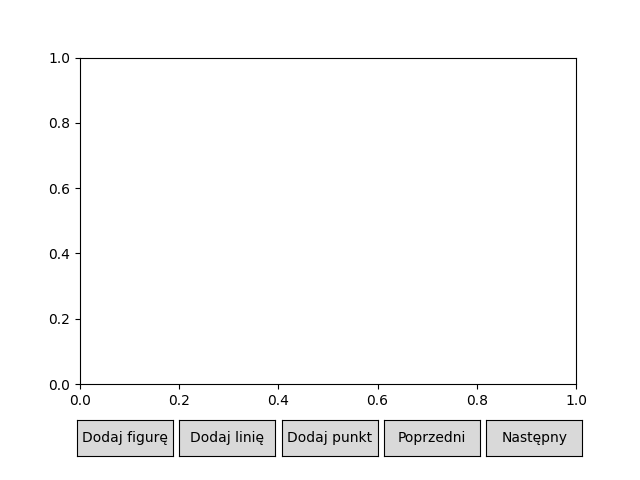

In [6]:
p = b.clear().add_pts(*pts_a, s=4).set_uniform_scale((-100, 100), (-100, 100)).get_plot()
p.draw()

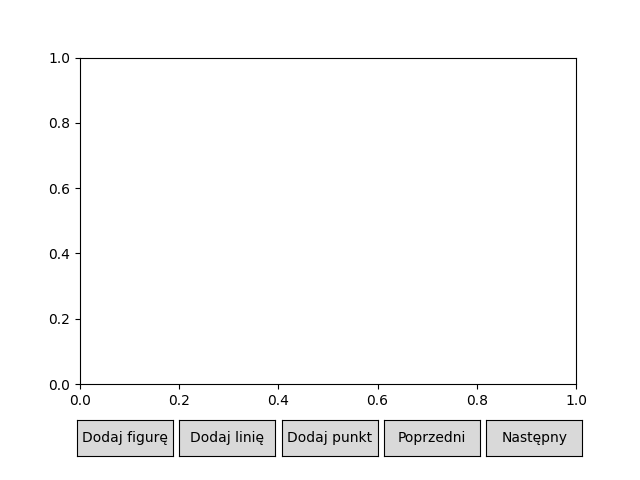

In [7]:
p = b.clear().add_pts(*pts_b, s=4).set_uniform_scale((-10, 10), (-10, 10)).get_plot()
p.draw()

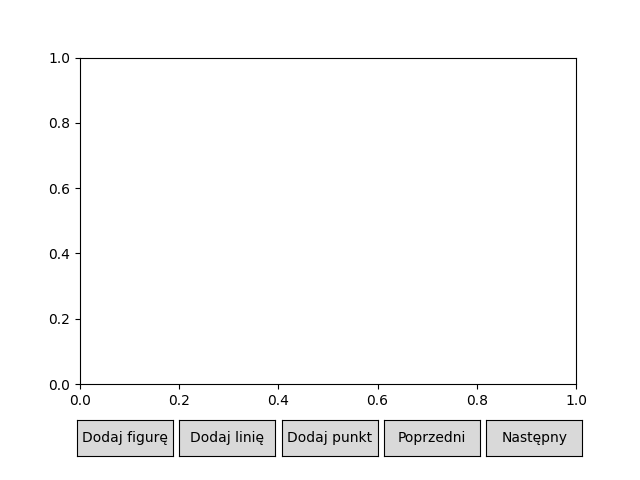

In [8]:
p = b.clear().add_pts(*pts_c, s=4).set_uniform_scale((-10, 10), (-10, 10)).get_plot()
p.draw()

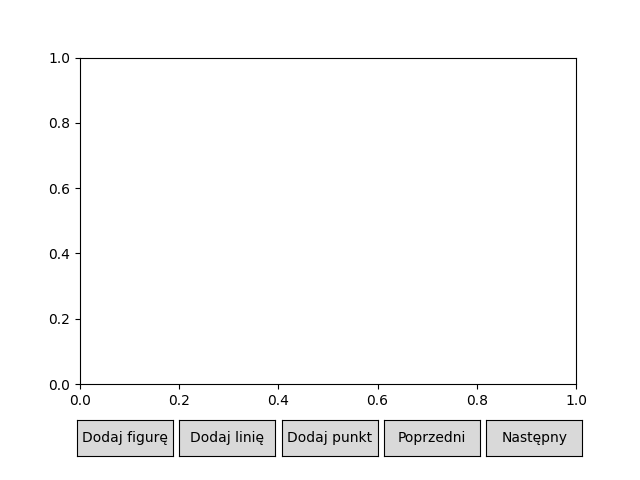

In [9]:
p = b.clear().add_pts(*pts_d, s=4).set_uniform_scale((0, 10), (0, 10)).get_plot()
p.draw()

In [10]:
def parametrised_gen_points(scheme, range_min=0, range_max=0, amount=0, centre=(0, 0), radius=0,
                            rect_lowerleft=(0, 0), rect_upperright=(0, 0), sq_lowerleft=(0, 0),
                            sq_upperright=(0, 0), amount_side=0, amount_diagonal=0):
    if scheme == 'a':
        return [ (np.random.uniform(range_min, range_max), np.random.uniform(range_min, range_max))
                 for _ in range(amount) ]

    if scheme == 'b':
        pts = []
        for _ in range(amount):
            t = np.random.uniform(-1, 1)
            pts.append( (centre[0]+np.cos(np.pi*t)*radius, centre[1]+np.sin(np.pi*t)*radius) )
        return pts

    if scheme == 'c':
        pts = []
        rect = [rect_lowerleft, rect_upperright]
        side_lengths = [rect[1][i] - rect[0][i] for i in range(2)]
        for _ in range(amount):
            side = np.random.randint(4)
            ax = side % 2
            if side < 2:
                corner = rect[0]
                t = np.random.uniform(corner[ax], corner[ax] + side_lengths[ax])
            else:
                corner = rect[1]
                t = np.random.uniform(corner[ax] - side_lengths[ax], corner[ax])
            pts.append((t, corner[1-ax]) if ax == 0 else (corner[1-ax], t))
        return pts

    if scheme == 'd':
        pts = [sq_lowerleft, (sq_lowerleft[0], sq_upperright[1]), (sq_upperright[0], sq_lowerleft[1]), sq_upperright]
        side_len = sq_upperright[0] - sq_lowerleft[0]
        for side in range(2):
            for _ in range(amount_side):
                if side == 0:
                    t = np.random.uniform(sq_lowerleft[1], sq_upperright[1])
                    pts.append((sq_lowerleft[0], t))
                else:
                    t = np.random.uniform(sq_lowerleft[0], sq_upperright[0])
                    pts.append((t, sq_lowerleft[1]))
        for diagonal in range(2):
            for _ in range(amount_diagonal):
                t = np.random.uniform(0, side_len)
                pts.append((sq_lowerleft[0]+t, sq_lowerleft[1]+t) if diagonal == 0 else (sq_lowerleft[0]+t, sq_upperright[1]-t))
        return pts

    return []

In [121]:
new_pts_a = parametrised_gen_points('a', range_min=-10**14, range_max=10**14, amount=100)
new_pts_b = parametrised_gen_points('b', centre=(3, -3), radius=5, amount=1000)
new_pts_c = parametrised_gen_points('c', rect_lowerleft=(-5, 2), rect_upperright=(-4, 10), amount=1000)
new_pts_d = parametrised_gen_points('d', sq_lowerleft=(1, -3), sq_upperright=(4, 0), amount_side=250, amount_diagonal=200)

In [119]:
def gen_bulk_test_data():
    dt = {'a': {'regular': pts_a.copy()}, 'b': {'regular': pts_b.copy()},
          'c': {'regular': pts_c.copy()}, 'd': {'regular': pts_d.copy()}}
    for scheme in ('a', 'b', 'c', 'd'):
        for amount in (100, 1000, 10000, 100000):
            dt[scheme][str(amount)] = parametrised_gen_points(scheme,
                amount=amount, amount_side=amount//4, amount_diagonal=amount//5,  # amounts
                range_min=-10**14, range_max=10**14,                              # scheme 'a'
                centre=(-5000, -10000), radius=10000,                             # scheme 'b'
                rect_lowerleft=(-5000, -10000), rect_upperright=(5000, 20000),    # scheme 'c'
                sq_lowerleft=(50000, 0), sq_upperright=(60000, 10000))            # scheme 'd'
    return dt

In [120]:
import pickle
test_data = gen_bulk_test_data()
with open('data/test_data.pickle', 'wb') as f:
    pickle.dump(test_data, f)

In [11]:
import pickle

with open('data/test_data.pickle', 'rb') as f:
    test_data = pickle.load(f)

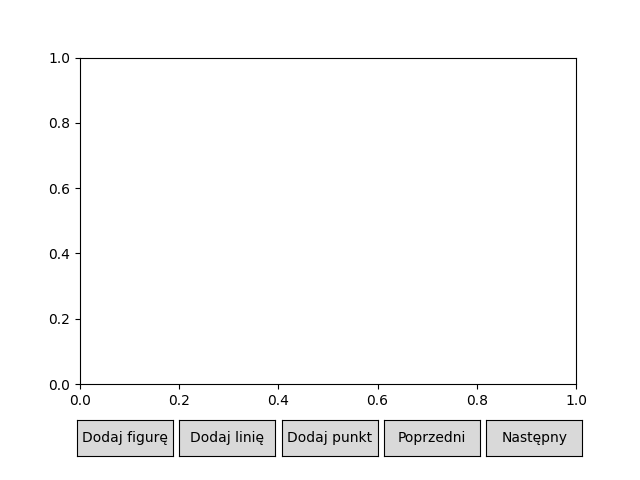

In [14]:
p = b.clear().add_pts(*test_data['a']['10000']).set_uniform_scale((-10**14, 10**14), (-10**14, 10**14)).get_plot()
p.draw()

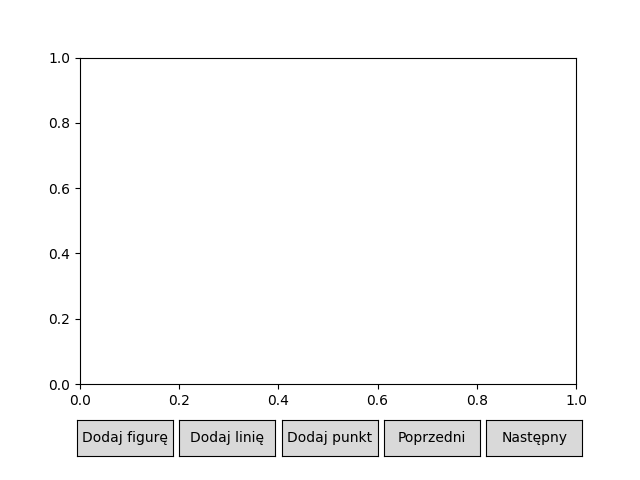

In [15]:
p = b.clear().add_pts(*test_data['b']['1000']).set_uniform_scale((-15000, 5000), (-20000, 0)).get_plot()
p.draw()

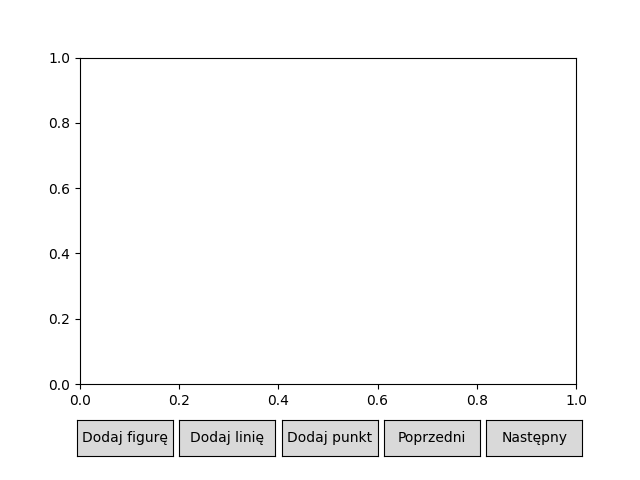

In [16]:
p = b.clear().add_pts(*test_data['c']['1000']).set_uniform_scale((-5000, 5000), (-10000, 20000)).get_plot()
p.draw()

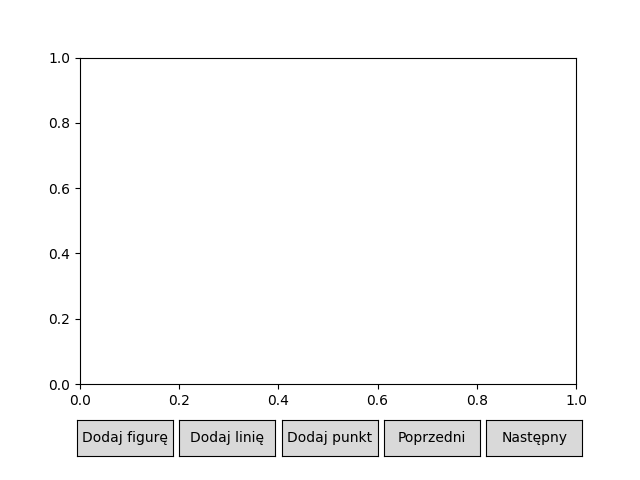

In [17]:
p = b.clear().add_pts(*test_data['d']['1000']).set_uniform_scale((50000, 60000), (0, 10000)).get_plot()
p.draw()

4. Zaimplementuj algorytmy Grahama oraz Jarvisa wyznaczające otoczkę wypukłą dla
zadanego zbioru punktów. Przetestuj program na zbiorach z punktu 1 oraz
zmodyfikowanych zbiorach z punktu 3. Program powinien pozwolić na zapisanie w
pliku wyniku działania, czyli ciągu wierzchołków otoczki. Dodaj możliwość
sprawdzenia czasu działania algorytmu.

In [189]:
import math
from collections import deque
from functools import cmp_to_key

import numpy as np


#################### WYZNACZNIK ####################
# Typ o wysokiej precyzji - dostępny tylko na niektórych platformach
PLATFORM_HAS_HPREC = hasattr(np, 'float128')
if not PLATFORM_HAS_HPREC:
    print('Uwaga: Platforma nie obsługuje typu o wysokiej precyzji.')
    hprec_type = np.float64
else:
    hprec_type = np.float128

def det_3x3(a, b, c, hprec=False):
    if hprec:
        ax, ay = hprec_type(a[0]), hprec_type(a[1])
        bx, by = hprec_type(b[0]), hprec_type(b[1])
        cx, cy = hprec_type(c[0]), hprec_type(c[1])
        return hprec_type(ax*by + bx*cy + cx*ay - cx*by - ax*cy - bx*ay)
    ax, ay = a
    bx, by = b
    cx, cy = c
    return np.float64(math.fsum([ax*by, bx*cy, cx*ay, -cx*by, -ax*cy, -bx*ay]))
#################### WYZNACZNIK ####################


def ch_graham(pts, eps=10**(-12), drawing_data=None, hprec=False):
    cmp = lambda b, c: -det_3x3(p_0, b, c)      # KOMPARATOR

    p_0 = min(pts, key=lambda p: (p[1], p[0]))
    sorted_pts = sorted([pt for pt in pts if pt != p_0], key=cmp_to_key(cmp))
    N = len(sorted_pts)

    consider = [True for _ in sorted_pts]
    prev_i = 0
    for i in range(1, N):
        pt = sorted_pts[i]
        prev_pt = sorted_pts[prev_i]
        if abs(det_3x3(p_0, pt, prev_pt, hprec=hprec)) < eps:
            if pt[1] > prev_pt[1] or (pt[1] == prev_pt[1] and pt[0] > prev_pt[0]):
                consider[prev_i] = False
                prev_i = i
            else:
                consider[i] = False
        else:
            prev_i = i

    s = deque([p_0])
    i = 0
    while len(s) < 3:
        if consider[i]:
            s.append(sorted_pts[i])
        i += 1

    while i < N:
        if not consider[i]:
            i += 1
            continue

        if drawing_data is not None:
            drawing_data.append({'ch_pts': list(s), 'curr_pt': sorted_pts[i]})

        if det_3x3(s[-2], s[-1], sorted_pts[i], hprec=hprec) > eps:
            s.append(sorted_pts[i])
            i += 1
        else:
            s.pop()

    return list(s)


def ch_jarvis(pts, eps=10**(-12), drawing_data=None, hprec=False):
    N = len(pts)
    p_0 = min(pts, key=lambda p: (p[1], p[0]))
    i_0 = pts.index(p_0)

    dist = lambda a, b: math.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)

    ch = [p_0]
    i = None
    while i != i_0:
        if i is None:
            i = i_0
        k = None
        for j in range(N):
            if i == j:
                continue
            if k is None:
                k = j
                continue
            det = det_3x3(pts[i], pts[k], pts[j], hprec=hprec)
            if det < -eps:
                k = j
            elif det < eps and dist(pts[i], pts[j]) > dist(pts[i], pts[k]):
                k = j

        if drawing_data is not None:
            drawing_data.append({'ch_pts': ch.copy(), 'curr_pt': pts[k]})

        if k != i_0:
            ch.append(pts[k])
        i = k

    return ch

In [200]:
import multiprocessing
import pickle
from time import perf_counter


def ch_wrapper(pts, ch_fun, time=False, save_mode=None, save_as=None, eps=10**(-12), drawing_data=None, hprec=False, time_limit=60):
    def ch_fun_wrapper(ch_fun, rval, *args, **kwargs):
        rval.put(ch_fun(*args, **kwargs))

    q = multiprocessing.Queue()
    p = multiprocessing.Process(target=ch_fun_wrapper, name='convex_hull_calc', args=(ch_fun, q, pts, eps, drawing_data, hprec))
    p.start()
    t_s = perf_counter()
    p.join(time_limit)
    t_e = perf_counter()
    if p.is_alive():
        p.terminate()
        print('Time limit exceeded!')
        p.join()
        return []
    ch = q.get()

    if time:
        print(f'Time: {t_e - t_s} s')

    if save_mode == 'serialise':
        with open(save_as if save_as is not None else 'ch_data.pickle', 'wb') as f:
            pickle.dump(ch, f)
    if save_mode == 'text':
        with open(save_as if save_as is not None else 'ch_data.txt', 'w') as f:
            for pt in ch:
                f.write(f'{pt}\n')

    return ch

In [209]:
ch = ch_wrapper(test_data['b']['10000'].copy(), ch_graham, time=True, eps=10**(-6), hprec=False, time_limit=180)
print(len(ch))

Time limit exceeded!
0


In [179]:
possible_eps = (10**(-6), 10**(-8), 10**(-10), 10**(-12))

for p_set, td in test_data.items():
    print(f'POINTS SET {p_set}')
    for eps in possible_eps:
        print(f'  {eps=}')
        for n, pts in td.items():
            p = pts.copy()
            np.random.shuffle(p)
            print(f'    {n=}\n        GRAHAM ', end='')
            g = ch_wrapper(p, ch_graham, time=True, save_mode='serialise', save_as=f'ch_data_{p_set}_{eps}_{n}_graham.pickle', time_limit=60, eps=eps)
            print(f'               {len(g)} points\n        JARVIS ', end='')
            g = ch_wrapper(p, ch_jarvis, time=True, save_mode='serialise', save_as=f'ch_data_{p_set}_{eps}_{n}_jarvis.pickle', time_limit=60, eps=eps)
            print(f'               {len(g)} points')

POINTS SET a
  eps=1e-06
    n='regular'
        GRAHAM Time: 0.02260530999956245 s
               12 points
        JARVIS Time: 0.03784644799998205 s
               12 points
    n='100'
        GRAHAM Time: 0.026949867999064736 s
               14 points
        JARVIS Time: 0.03503222400104278 s
               14 points
    n='1000'
        GRAHAM Time: 0.05604808300086006 s
               19 points
        JARVIS Time: 0.06666900600066583 s
               19 points
    n='10000'
        GRAHAM Time: 0.2828661750008905 s
               27 points
        JARVIS Time: 0.4780176479998772 s
               27 points
    n='100000'
        GRAHAM Time: 3.4028383059994667 s
               25 points
        JARVIS Time: 3.9075042119984573 s
               25 points
  eps=1e-08
    n='regular'
        GRAHAM Time: 0.02194704300018202 s
               12 points
        JARVIS Time: 0.024608759000329883 s
               12 points
    n='100'
        GRAHAM Time: 0.020717288000014378 s
       

4. cd. Uruchom aplikację graficzną tak, aby można było zilustrować graficznie poszczególne
kroki realizacji algorytmu. Jednym kolorem powinny być zaznaczone wszystkie punkty
zbioru wyjściowego, drugim kolorem boki aktualnie rozpatrywane, a trzecim boki
wielokąta otoczki. Po zakończeniu wyznaczania otoczki wierzchołki otoczki powinny
być wyróżnione (osobnym kolorem bądź kształtem).

In [232]:
def get_regular_plot(pts, ch, xlim=None, ylim=None, ch_pts_above=False):
    b = geowrapper.BetterPlot()
    b.clear()
    if not ch_pts_above:
        b.add_polygon(ch, c='royalblue', w=2, c_p='cyan', s=50)
    b.add_pts(*[p for p in pts if p not in ch], s=10, c='black')
    if ch_pts_above:
        b.add_polygon(ch, c='royalblue', w=2, c_p='cyan', s=50)
    if xlim is not None:
        b.set_uniform_scale(xlim, ylim)
    return b.get_plot()


def get_step_plot(pts, ch_fun, eps):
    p_list = pts.copy()
    drawing_data = []
    ch = ch_fun(p_list, drawing_data=drawing_data, eps=eps)

    b = geowrapper.BetterPlot()
    b.clear()
    for step in drawing_data:
        b.add_pts(*p_list, s=10, c='black')
        b.add_polygon(step['ch_pts'], close=False, draw_pts=False, c='green', w=2)
        b.add_lines((step['ch_pts'][-1], step['curr_pt']), c='red', w=2)
        b.save_scene_cls()
    b.add_polygon(ch, c='royalblue', w=2, c_p='cyan', s=50)
    b.add_pts(*[p for p in p_list if p not in ch], s=10, c='black')
    b.save_scene_cls()
    return b.get_plot()

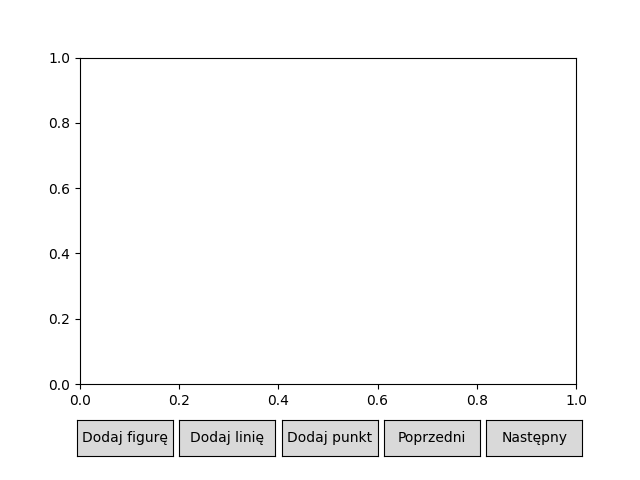

In [220]:
with open('ch_data_a_regular_graham.pickle', 'rb') as f:
    ch = pickle.load(f)
p = get_regular_plot(test_data['a']['regular'], ch, (-100, 100), (-100, 100))
p.draw()

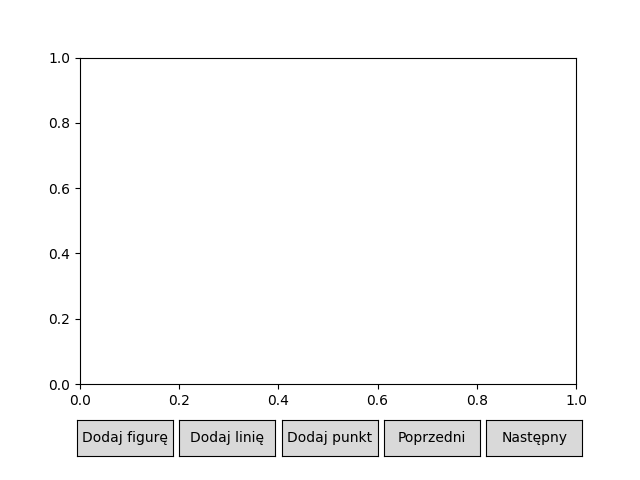

In [224]:
with open('ch_data_b_regular_graham.pickle', 'rb') as f:
    ch = pickle.load(f)
p = get_regular_plot(test_data['b']['regular'], ch, (-10, 10), (-10, 10))
p.draw()

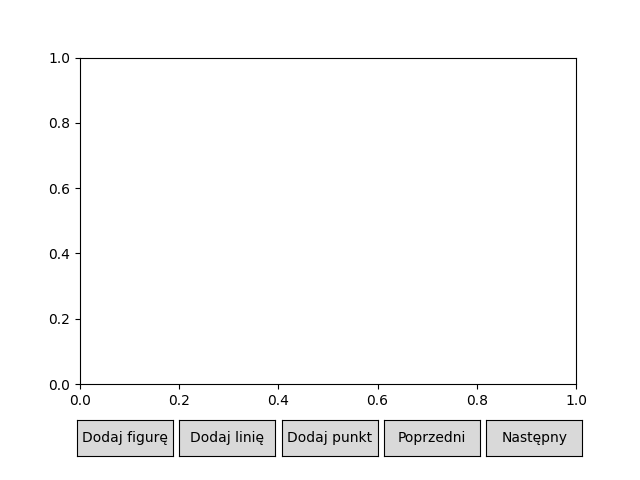

In [225]:
with open('ch_data_c_regular_graham.pickle', 'rb') as f:
    ch = pickle.load(f)
p = get_regular_plot(test_data['c']['regular'], ch, (-10, 10), (-10, 10))
p.draw()

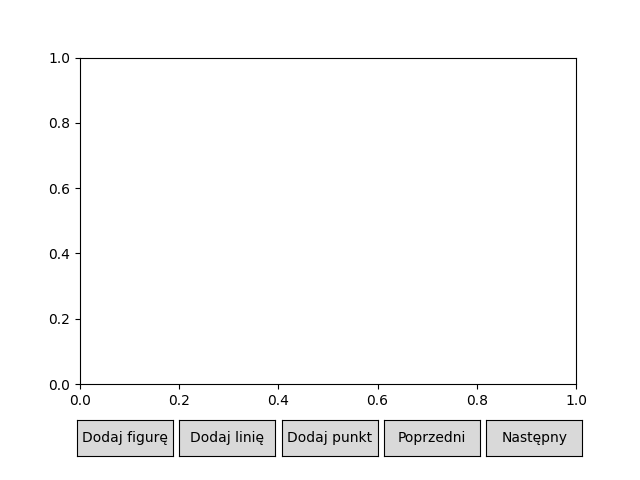

In [227]:
with open('ch_data_d_regular_graham.pickle', 'rb') as f:
    ch = pickle.load(f)
p = get_regular_plot(test_data['d']['regular'], ch, (0, 10), (0, 10))
p.draw()

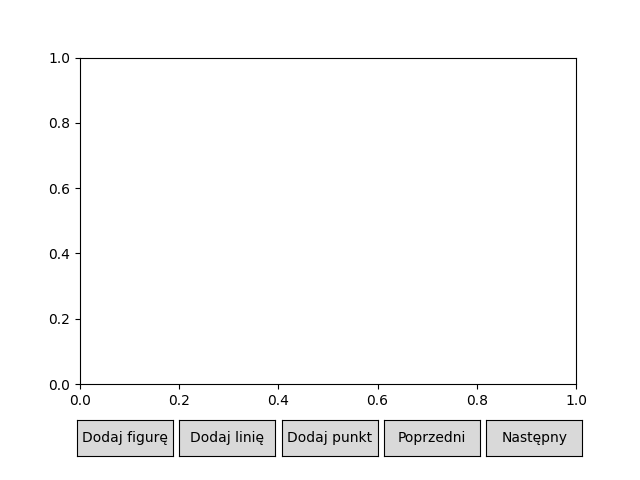

In [233]:
with open('ch_data_a_10000_graham.pickle', 'rb') as f:
    ch = pickle.load(f)
p = get_regular_plot(test_data['a']['10000'], ch, (-10**(14), 10**(14)), (-10**(14), 10**(14)), ch_pts_above=True)
p.draw()

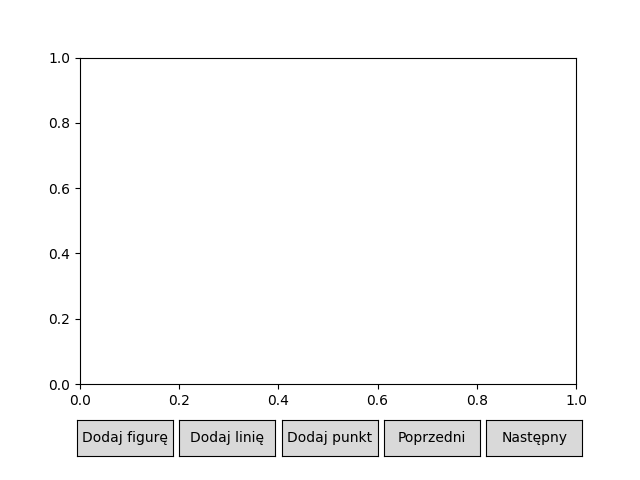

In [236]:
with open('ch_data_b_1000_graham.pickle', 'rb') as f:
    ch = pickle.load(f)
p = get_regular_plot(test_data['b']['1000'], ch, (-15000, 5000), (-20000, 0), ch_pts_above=True)
p.draw()

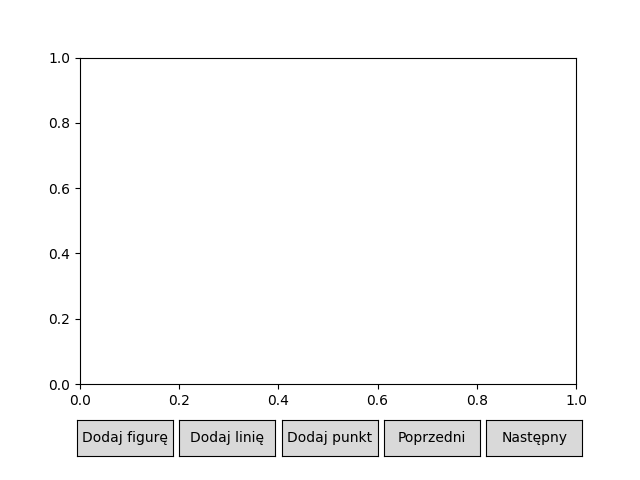

In [241]:
with open('ch_data_c_1000_graham.pickle', 'rb') as f:
    ch = pickle.load(f)
p = get_regular_plot(test_data['c']['1000'], ch, (-5000, 5000), (-10000, 20000), ch_pts_above=True)
p.draw()

4


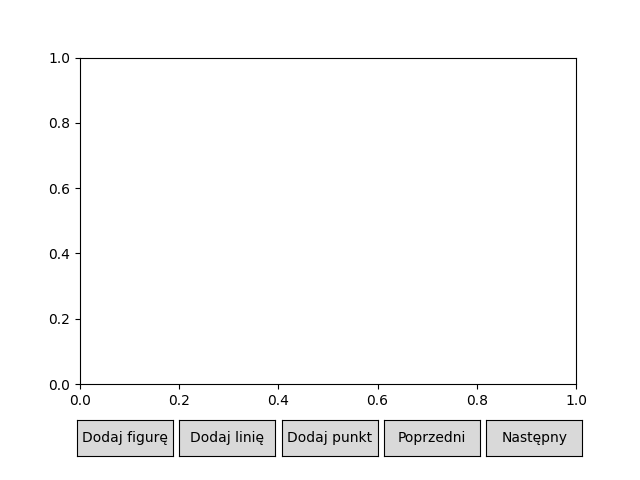

In [246]:
with open('ch_data_d_1000_jarvis.pickle', 'rb') as f:
    ch = pickle.load(f)
print(len(ch))
p = get_regular_plot(test_data['d']['1000'], ch, (50000, 60000), (0, 10000), ch_pts_above=True)
p.draw()

103


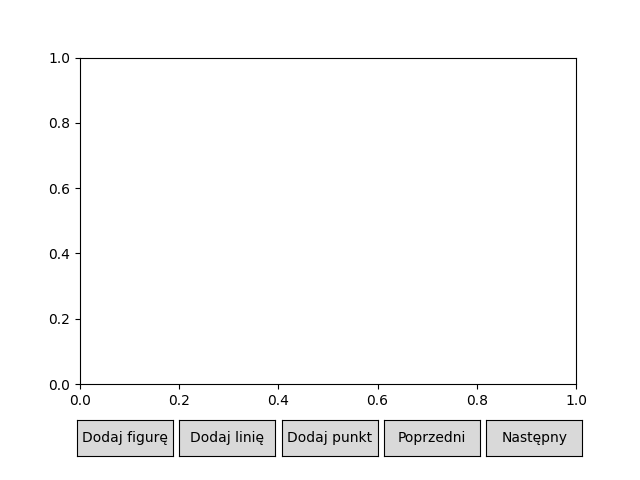

In [249]:
with open('ch_data_d_1e-12_1000_graham.pickle', 'rb') as f:
    ch = pickle.load(f)
print(len(ch))
p = get_regular_plot(test_data['d']['1000'], ch, (50000, 60000), (0, 10000), ch_pts_above=True)
p.draw()

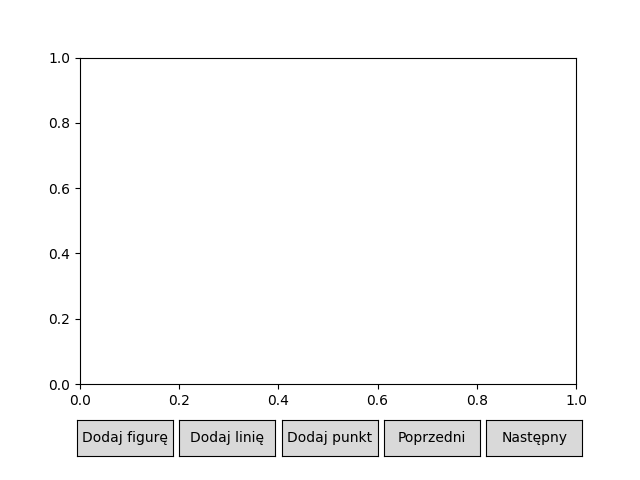

In [229]:
p = get_step_plot(test_data['a']['regular'], ch_graham, 10**(-12))
p.draw()

4


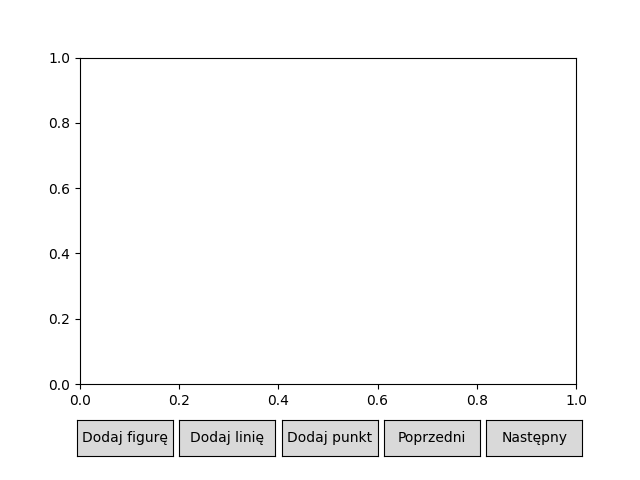

In [184]:
EPS=10**(-6)

p = get_step_plot(test_data['d']['100'], ch_graham, EPS)
p.draw()